In [59]:
import os
from pathlib import Path

import cv2 as cv
import matplotlib
import numpy as np
from dotenv import load_dotenv
from matplotlib import pyplot as plt
from scipy.signal import find_peaks

from utils.general import integral_intensity_projection
from utils.preprocess import rotate_point
from utils.shortcut import get_fake_result
from utils.yolo import get_teeth_ROI

load_dotenv()
matplotlib.use('module://matplotlib_inline.backend_inline')

# %matplotlib inline


In [60]:
data_dir = Path(os.getenv('DATASET_DIR')) / 'phase-2'
data_dir


PosixPath('/Users/lucyxu/PycharmProjects/datasets/phase-2')

In [61]:
plt.gray()

image_paths = list(data_dir.glob('00008026.jpg'))
# image_paths = list(data_dir.glob('00006145.jpg'))
# image_paths = list(data_dir.glob('*.jpg'))
image_paths[0].name


'00008026.jpg'

In [66]:

from utils.edge import fill_rotate, get_rotation_angle, gum_jaw_separation


class ImageEdge:
    tooth_number_dict = {
        'upper': {
            'left': ['17', '13'],
            'right': ['23', '27'],
            'middle': ['13', '23']
        },
        'lower': {
            'left': ['47', '43'],
            'right': ['33', '37'],
            'middle': []
        },
    }

    zooming_margin = 30

    def __init__(self, image_path, model=None):
        self.im_global = cv.imread(str(image_path), cv.IMREAD_GRAYSCALE)

        self.image_path = image_path
        self.filename = image_path.stem

        # Set up roi
        if model:
            results = model(self.image_path)
        else:
            results = get_fake_result(self.image_path)

        self.template_points = {
            'upper': [],
            'lower': []
        }

        teeth_roi = get_teeth_ROI(results)
        self.teeth_roi_images = teeth_roi['images'][self.filename]
        self.split_teeth = teeth_roi['split_teeth'][self.filename]

        for number, split_tooth in self.split_teeth.items():
            tooth_im = cv.cvtColor(split_tooth['crop_image'], cv.COLOR_RGBA2GRAY)
            number = int(number)

            split_tooth['crop_image'] = tooth_im
            split_tooth['image_rotated'] = tooth_im
            split_tooth['xyxy'] = split_tooth['xyxy'].int().numpy().squeeze()
            # TODO Get the theta from the tooth not the region.
            split_tooth['angle'] = 0

            split_tooth['flag'] = 'upper' if number // 10 < 3 else 'lower'

        # self.set_up_roi()
        self.set_up_roi_new()

    def set_up_roi_new(self):
        for target_roi in self.teeth_roi_images:
            target_roi['image'] = cv.cvtColor(target_roi['image'], cv.COLOR_RGBA2GRAY)

            flag = target_roi['flag']
            tooth_position = target_roi['tooth_position']
            source = target_roi['image']

            theta = get_rotation_angle(source, flag=flag, tooth_position=tooth_position)
            source_rotated = fill_rotate(self.im_global, target_roi['xyxy'], theta)

            target_roi['image_rotated'] = source_rotated

            for number in self.tooth_number_dict[flag][tooth_position]:
                split_tooth = self.split_teeth[number]

                if theta != 0:
                    split_tooth['angle'] = theta
                    split_tooth['image_rotated'] = fill_rotate(self.im_global, split_tooth['xyxy'], theta)

        for number, split_tooth in self.split_teeth.items():
            theta = split_tooth['angle']
            im_tooth = split_tooth['crop_image']
            im_tooth_rotated = split_tooth['image_rotated']
            xyxy_tooth = split_tooth['xyxy']
            flag = split_tooth['flag']

            h, w = im_tooth_rotated.shape

            init_gap = self.find_global_gap_by_tooth(split_tooth)
            self.template_points[flag].append(init_gap[0])
            self.template_points[flag].append(init_gap[1])

            # local_gap = init_gap - xyxy_tooth[:2]

            hw_matrix = np.array([[0, 0],
                                  [w, 0],
                                  [w, h],
                                  [0, h]])

            # plt.imshow(1 - im_tooth_rotated)
            # plt.axhline(gum_sep_line)
            # plt.show()

            # break

        # plt.imshow(1 - self.im_global)
        # for i in self.template_points['upper']:
        #     plt.axline(*i[:2])
        #     plt.axline(*i[2:])
        # plt.show()

    def set_up_roi(self):
        for target_roi in self.teeth_roi_images:
            target_roi['image'] = cv.cvtColor(target_roi['image'], cv.COLOR_RGBA2GRAY)

            flag = target_roi['flag']
            tooth_position = target_roi['tooth_position']
            source = target_roi['image']

            theta = get_rotation_angle(source, flag=flag, tooth_position=tooth_position)
            source_rotated = fill_rotate(self.im_global, target_roi['xyxy'], theta)

            target_roi['image_rotated'] = source_rotated

            gum_sep_line, jaw_sep_line, hor_valleys, hor = gum_jaw_separation(source_rotated, flag=flag, margin=0)

            if flag == 'upper':
                y1 = gum_sep_line - self.zooming_margin
                y2 = jaw_sep_line
            else:
                y1 = jaw_sep_line
                y2 = gum_sep_line + self.zooming_margin

            _, w = source_rotated.shape
            gum_rotated_matrix = np.array([[0, gum_sep_line],
                                           [w, gum_sep_line]])

            target_roi['image_zooming'] = source_rotated[y1:y2, :]
            target_roi['image_zooming_xyxy'] = np.array([])

            target_roi['gum_sep_line'] = gum_sep_line
            target_roi['jaw_sep_line'] = jaw_sep_line
            target_roi['angle'] = theta

            # Get gum line global
            gum_sep_line_global = rotate_point(theta, target_roi['image'].shape, gum_rotated_matrix, recovery=True)
            gum_sep_line_global = gum_sep_line_global + target_roi['xyxy'].numpy()[:2]
            target_roi['gum_sep_line_global'] = gum_sep_line_global

            # gum jaw line on rotated image
            # print(gum_sep_line, jaw_sep_line)
            # plt.imshow(1 - source_rotated)
            # plt.axhline(gum_sep_line)
            # plt.axhline(jaw_sep_line)
            # plt.show()

            # plt.imshow(1 - source_rotated)
            # plt.scatter(*gum_rotated_matrix[0])
            # plt.scatter(*gum_rotated_matrix[1])
            # plt.show()

            # plt.imshow(1 - self.im_global)
            # plt.scatter(*gum_sep_line_global[0])
            # plt.scatter(*gum_sep_line_global[1])
            # plt.show()

            # Split teeth set up
            # number = self.tooth_number_dict[flag][tooth_position][0]
            # TODO fix point init repeat problem
            for number in self.tooth_number_dict[flag][tooth_position]:
                split_tooth = self.split_teeth[number]

                if theta != 0:
                    self.split_teeth[number]['angle'] = theta

                init_gap = self.find_global_gap_by_tooth(split_tooth)

                self.template_points[flag].append(init_gap)
        for number, split_tooth in self.split_teeth.items():
            theta = split_tooth['angle']

            # init_gap = self.find_global_gap_by_tooth(split_tooth['crop_image'], split_tooth['xyxy'], theta,
            #                                          gum_sep_line_global)

            # self.template_points[flag].append(init_gap)

        for flag in ('upper', 'lower'):
            points = self.template_points[flag]
            points = np.vstack(points)
            points = points[np.argsort(points[:, 0])]

            self.template_points[flag] = points

    @staticmethod
    def find_local_gap_by_tooth(im_tooth, flag):
        """
        This function finds the local minima of an image of a tooth.
        Args:
            im_tooth: A 2-D array representing an image of a tooth
            flag: A flag denote the tooth is in upper or lower

        Returns:
            gaps: The location of the local minima in an array
            gaps_intensity: The intensity of the local minima in the image
        """
        # Get the height and width of the tooth
        im_tooth = cv.equalizeHist(im_tooth)
        h, w = im_tooth.shape
        gum_pos = h / 5 * 3 if flag == 'upper' else h / 5 * 2
        gum_pos = int(gum_pos)
        margin = 40
        radius = 6

        im_tooth_zoom = im_tooth[gum_pos - margin:gum_pos + margin, :]

        # Get the integral intensity projection of the tooth
        hor, ver = integral_intensity_projection(im_tooth_zoom)

        # Get the inverse of the ver projection
        ver_inverse = ver.max() - ver
        hor_inverse = hor.max() - hor

        # Find the peaks of the ver_inverse
        peaks, _ = find_peaks(ver_inverse, height=0)
        hor_peaks, _ = find_peaks(hor_inverse, height=0)

        gum_pos_fix = hor_peaks[np.argmin(hor[hor_peaks])] + (gum_pos - margin)

        # Get the peaks from left and right
        peaks_left = peaks[peaks < w / 2]
        peaks_right = peaks[peaks > w / 2]

        # Get the local minima from the left and right peaks
        left_gap_pose = peaks_left[ver[peaks_left].argmin()]
        right_gap_pose = peaks_right[ver[peaks_right].argmin()]

        left_gap_pose += max(radius - left_gap_pose, 0)
        right_gap_pose -= max(radius - (w - right_gap_pose), 0)

        gap_poses = np.array((left_gap_pose, right_gap_pose))

        gaps = np.array([
            [gap_poses[0], gum_pos_fix],
            [gap_poses[1], gum_pos_fix]
        ])

        mask = np.zeros((h, w), im_tooth.dtype)
        left_mask = cv.circle(mask, gaps[0], radius, 255, -1)
        mask = np.zeros((h, w), im_tooth.dtype)
        right_mask = cv.circle(mask, gaps[1], radius, 255, -1)

        left_im_masked = np.bitwise_and(im_tooth, left_mask)
        right_im_masked = np.bitwise_and(im_tooth, right_mask)

        gaps_intensity = [np.sum(left_im_masked), np.sum(right_im_masked)]

        # Plot
        # fig, axes = plt.subplots(nrows=1, ncols=2)
        #
        # axes[0].imshow(1 - im_tooth)
        # axes[0].scatter(*gaps[0], s=radius ** 2)
        # axes[0].scatter(*gaps[1], s=radius ** 2)
        #
        # index = range(gum_pos - margin, gum_pos + margin)
        # axes[1].plot(hor, index)
        # axes[1].plot(hor[hor_peaks], hor_peaks + (gum_pos - margin), 'x')
        # axes[1].set_ylim(h, 0)
        #
        # plt.show()

        gap_lines = []
        for gap_pos in gap_poses:
            gap_lines.append([gap_pos, 0])
            gap_lines.append([gap_pos, h])
        gap_lines = np.array(gap_lines)

        return gaps, gap_lines, gaps_intensity

    # TODO make sure the gap distance in normal distance
    def find_global_gap_by_tooth(self, split_tooth):
        tooth_im = split_tooth['crop_image']
        tooth_im_rotated = split_tooth['image_rotated']

        theta = split_tooth['angle']
        tooth_xyxy = split_tooth['xyxy']
        flag = split_tooth['flag']

        # Find gap beside tooth
        gaps_r, gap_lines_r, gaps_intensity_r = self.find_local_gap_by_tooth(tooth_im_rotated, flag)
        gaps_o, gap_lines_o, gaps_intensity_o = self.find_local_gap_by_tooth(tooth_im, flag)

        # Get gap line global
        gap_matrix_r = rotate_point(theta, tooth_im.shape, gaps_r, recovery=True)
        gap_matrix_r = gap_matrix_r + tooth_xyxy[:2]

        ## Recovery w/o theta
        gap_matrix_o = gaps_o + tooth_xyxy[:2]

        gap_matrix = gap_matrix_r.copy()
        left_gap_flag = gaps_intensity_r[0] < gaps_intensity_o[0]
        right_gap_flag = gaps_intensity_r[1] < gaps_intensity_o[1]
        gap_matrix[0] = gap_matrix_r[0] if left_gap_flag else gap_matrix_o[0]
        gap_matrix[1] = gap_matrix_r[1] if right_gap_flag else gap_matrix_o[1]

        # Plot
        # plt.imshow(1 - self.im_global)
        # plt.scatter(*gap_matrix[0])
        # plt.scatter(*gap_matrix[1])
        # plt.show()
        #
        # gaps = gap_matrix - tooth_xyxy[:2]
        # plt.imshow(1 - tooth_im)
        # plt.scatter(*gaps[0])
        # plt.scatter(*gaps[1])
        # plt.show()

        return gap_matrix

    def find_gap_in_roi(self):
        for target_roi in self.teeth_roi_images:
            flag = target_roi['flag']
            tooth_position = target_roi['tooth_position']
            xyxy = target_roi['xyxy'].numpy()
            init_gaps = self.template_points[flag]

            # Select gap in roi
            ge = init_gaps >= xyxy[:2]
            le = init_gaps <= xyxy[2:]

            t = np.where(np.all(ge, axis=1) & np.all(le, axis=1))[0]
            init_gap_index = np.array([t[0] - 1, t[0], t[1], t[1] + 1])

            # Change gap's axis to zooming roi
            init_gaps = init_gaps[init_gap_index]
            init_gaps -= xyxy[:2]

            init_gaps = rotate_point(target_roi['angle'], target_roi['image'].shape, init_gaps)

            if flag == 'upper':
                margin_line = self.zooming_margin
                offset = target_roi['gum_sep_line'] - self.zooming_margin
            else:
                h, _ = target_roi['image_zooming'].shape
                margin_line = h - self.zooming_margin
                offset = target_roi['jaw_sep_line']

            init_gaps[:, 1] = [margin_line] * init_gaps[:, 1].shape[0]

            # Calc new gap
            if tooth_position != 'middle':
                # Add factor here
                left_size = (init_gaps[1] - init_gaps[0])
                right_size = (init_gaps[3] - init_gaps[2])

                point1 = init_gaps[1] + left_size
                point2 = init_gaps[2] - right_size

                gaps = np.array([point1, point2])
            else:
                tooth_step = (init_gaps[2] - init_gaps[1]) / 4
                gaps = np.array([init_gaps[1] + tooth_step * i for i in range(1, 4)])

            # Transform back to global
            target_roi['zooming_gaps'] = np.concatenate((init_gaps, gaps), axis=0)

            gaps_global = gaps.copy()
            gaps_global += [0, offset]
            gaps_global = rotate_point(target_roi['angle'], target_roi['image'].shape, gaps_global, recovery=True)
            gaps_global += xyxy[:2]

            self.template_points[flag] = np.concatenate((self.template_points[flag], gaps_global), axis=0)

            plt.imshow(1 - target_roi['image_zooming'])
            for i in init_gaps:
                plt.scatter(*i)
            for i in gaps:
                plt.scatter(*i, color='green')
            plt.show()

            # break


a = ImageEdge(image_paths[0])
# a.split_teeth['13'].keys()


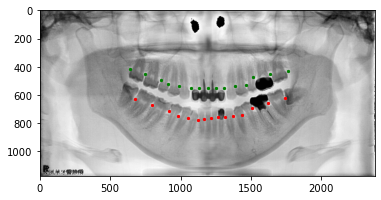

In [67]:
b = a.teeth_roi_images

plt.imshow(1 - a.im_global)
# for i in b:
#     plt.scatter(*i['gum_sep_line_global'][0])
#     plt.scatter(*i['gum_sep_line_global'][1])
plt.show()


In [69]:
b = a.template_points

print(b['upper'])

plt.imshow(1 - a.im_global)
for i in a.template_points['upper']:
    plt.scatter(*i, edgecolors='green')
for i in a.template_points['lower']:
    plt.scatter(*i, edgecolors='green')
plt.show()
